In [1]:
from sknetwork.ranking import top_k
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

from rag.config import settings, PROJECT_ROOT
from rag.ingestion import create_chunker
from rag.embeddings import create_embedder
from rag.retrieval import create_reranker
from rag.generation import create_llm
from rag.storage import (
    BaseDocumentStore,
    BaseVectorStore,
    Document,
    SearchResult,
    make_chunk_id,
    parse_chunk_id,
    InMemoryDocumentStore,
    FAISSVectorStore, PostgresDocumentStore, PgvectorVectorStore,
)

from datasets import load_dataset, Dataset

load_dotenv()

/home/ergot/projects/rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
embedder = create_embedder(settings)
chunker = create_chunker(settings)
reranker = create_reranker(settings)
llm = create_llm(settings)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 309.30it/s]


In [3]:
corpus_ds = load_dataset("rag-datasets/rag-mini-bioasq", "text-corpus")['passages']
queries_ds = load_dataset("rag-datasets/rag-mini-bioasq", "question-answer-passages")['test']

In [4]:
corpus_ds

Dataset({
    features: ['passage', 'id'],
    num_rows: 40221
})

In [5]:
corpus_ds = corpus_ds.filter(lambda row: row['passage'] != 'nan')

In [6]:
chunked_ds = chunker.chunk_dataset(corpus_ds, text_col='passage', id_col='id')

In [7]:
from rag.utils import batched

doc_store = InMemoryDocumentStore()

for batch in batched(chunked_ds):
    docs = [
        Document(
            id=row['chunk_id'],
            text=row['text'],
            doc_type='chunk',
            meta={'parent_id': row['doc_id']},
        ) for row in batch
    ]
    doc_store.add_documents(docs)

ValueError: Document 9797#0 must have doc_type='parent'

In [8]:
doc_store

InMemoryDocumentStore(count=64042)

In [9]:
doc_store.save(PROJECT_ROOT / 'data/doc_store.pkl')

In [10]:
from tqdm import tqdm

embedder = create_embedder(settings)

vec_store = FAISSVectorStore(
    embedder.dimension,
)

pbar = tqdm(total=doc_store.count_chunks())

for batch in doc_store.iter_chunks():
    texts = [x.text for x in batch]
    ids = [x.id for x in batch]
    embs = embedder.embed_batch(texts)
    vec_store.add(embs, ids)
    pbar.update(len(batch))

pbar.close()

100%|██████████| 64042/64042 [00:26<00:00, 2460.87it/s]


In [11]:
vec_store

FAISSVectorStore(count=64042, dimension=384, index_type=flat_ip)

In [12]:
vec_store.save(PROJECT_ROOT / 'data/vec_store')

In [13]:
i = 2
question = queries_ds[i]['question']

print('Question:', question)
print(80*'=')

q_emb = embedder.embed_text(question)
initial_results = vec_store.search(q_emb, k=settings.k)
for res in initial_results[:5]:
    print(doc_store.get_chunk(res.chunk_id).text)
    print(80*'=')

Question: Is the protein Papilin secreted?
Papilins are homologous, secreted extracellular matrix proteins which share a 
common order of protein domains. They occur widely, from nematodes to man, and 
can differ in the number of repeats of a given type of domain. Within one 
species the number of repeats can vary by differential RNA splicing. A 
distinctly conserved cassette of domains at the amino-end of papilins is 
homologous with a cassette of protein domains at the carboxyl-end of the ADAMTS 
subgroup of secreted, matrix-associated metalloproteases. Papilins primarily 
occur in basement membranes. Papilins interact with several extracellular matrix 
components and ADAMTS enzymes. Papilins are essential for embryonic development 
of Drosophila melanogaster and Caenorhabditis elegans.
A sulfated glycoprotein was isolated from the culture media of Drosophila Kc 
cells and named papilin. Affinity purified antibodies against this protein 
localized it primarily to the basement membran

In [14]:
res

SearchResult(chunk_id='23482462#1', score=0.7417332530021667, meta=None)

In [15]:
retrived_docs = [doc_store.get_by_id(r.chunk_id) for r in initial_results]

In [16]:
ranked = reranker.rerank(question, retrived_docs)
reranked_docs = ranked[:settings.top_k]
reranked_docs

[Document(id='15094122#0', text='Papilins are homologous, secreted extracellular matrix proteins which share a \ncommon order of protein domains. They occur widely, from nematodes to man, and \ncan differ in the number of repeats of a given type of domain. Within one \nspecies the number of repeats can vary by differential RNA splicing. A \ndistinctly conserved cassette of domains at the amino-end of papilins is \nhomologous with a cassette of protein domains at the carboxyl-end of the ADAMTS \nsubgroup of secreted, matrix-associated metalloproteases. Papilins primarily \noccur in basement membranes. Papilins interact with several extracellular matrix \ncomponents and ADAMTS enzymes. Papilins are essential for embryonic development \nof Drosophila melanogaster and Caenorhabditis elegans.', score=6.969378471374512, doc_type='chunk', meta={}),
 Document(id='11076767#0', text="Papilin is an extracellular matrix glycoprotein that we have found to be \ninvolved in, (1) thin matrix layers du

In [17]:
system_prompt = """You are a domain-careful, passage-bound assistant. You will be given:

CONTEXT: a list of dictionaries, each with keys:

text (string) — the passage content (use this only).

score (float) — Higher means more relevant. Use for tie-breaking, not as ground truth.

id (int or str) — unique identifier for citation (cite this).

QUESTION: the user’s query.

Ground Rules

Use Only the Provided Passages

All factual claims must come solely from text fields within CONTEXT.

Ignore any prior knowledge and external facts.

Cite by index

After each factual claim or at the end of a sentence/ bullet, cite like [idx=2025].

If multiple passages support a claim, cite the strongest 1–3 (prefer lower distance).

Be Concise, Direct, and Structured

Lead with a 1–3 sentence answer.

Use bullets for lists, mechanisms, pros/cons, steps, etc.

Include brief definitions only if needed to answer.

Rank & Filter Passages Sensibly

Prefer passages with lower distance, high topical match, and specific details.

De-duplicate overlapping content; don’t over-cite.

If passages conflict and can’t be resolved, state the disagreement and present both sides with citations.

No Fabrication

Do not invent numbers, dates, mechanisms, or terminology not explicitly present in text.

When Information Is Insufficient

Say: “I don’t have enough information in the provided passages to answer.”

Optionally list what’s missing (e.g., “mechanism”, “dates”, “definitions”).

Biomedical/Technical Care (if applicable)

Distinguish hypotheses vs. established findings when the wording is tentative.

Avoid over-generalization beyond what’s stated.

If species/setting (rodent vs. human, in vitro vs. in vivo) isn’t specified in the passages, don’t assume.

Working Steps (internal)

Parse CONTEXT; extract only text and note each item’s index and distance.

Identify passages most relevant to the QUESTION (favor lower distance).

Synthesize the answer strictly from the chosen passages.

Add minimal, targeted citations using [idx=…].

If conflicts remain unresolved, present both views briefly.

Input Format (exact)
======================== CONTEXT ================================
[{'text': '<passage 1 text>', 'distance': <float>, 'index': <int>},
 {'text': '<passage 2 text>', 'distance': <float>, 'index': <int>},
 ...
]
====================== QUESTION: <user question> ================

Output Format (default)
<Concise answer (1–3 sentences).>

- <Key point 1>. [doc_id=33378]
- <Key point 2>. [doc_id=37076, doc_id=33378]

Citations: [doc_id=33378], [doc_id=37076]

Insufficient Information
I don’t have enough information in the provided passages to answer. I would need <briefly state what is missing>.
Citations: —

Optional (if you want a quick audit trail)

After the answer (keep it short), you may append:

Relevance notes (brief):
- Used doc_id=37076 (lower distance, direct on H3 inverse agonism).
- Used doc_id=33378 (mechanistic distribution & function).
- Skipped doc_id=5234/2025/16517 (off-topic for QUESTION).
"""

prompt = f"""
======================== CONTEXT ================================
{[doc.to_dict() for doc in reranked_docs]}

====================== QUESTION: {question} ================"""

answer = llm.generate(
    prompt=prompt,
    system_prompt=system_prompt,
    max_tokens=1000,
    temperature=0.01,
)

print(answer)

Papilin is secreted. [idx=15094122#0], [idx=11076767#0], [idx=12666201#0]

Relevance notes:
- Used idx=15094122#0 (direct statement on secreted nature).
- Used idx=11076767#0 (functional roles indicating secretion).
- Used idx=12666201#0 (developmental patterns suggesting secretion).


In [18]:
print(queries_ds[i]['answer'])
print(queries_ds[i]['relevant_passage_ids'])

Yes,  papilin is a secreted protein
[21784067, 19297413, 15094122, 7515725, 3320045, 20805556, 19724244, 12666201, 15094110, 11076767]


In [19]:
from rag.pipeline import RAGPipeline

pipe = RAGPipeline(
    doc_store,
    vec_store,
    embedder,
    reranker,
    llm,
    settings,
)

In [22]:
i = 105
question = queries_ds['question'][i]

print('============== QUESTION =============')
print(question, '\n')

print('=============== RAG ANSWER =============')
answer = pipe.query(question)
print(answer, '\n')

print('=============== TRUE ANSWER ================')
print(queries_ds[i]['answer'])
print(queries_ds[i]['relevant_passage_ids'])

============== QUESTION =============
Which is the human selenoprotein that contains several Se-Cys residues? 

=============== RAG ANSWER =============
('- Selenoprotein P is unique among human selenoproteins in containing 10-12 selenocysteine residues, depending on the species. [idx=10692426#0]\n- The human selenoprotein P (HSelP) contains 10 selenocysteines encoded by in-frame UGA codons. [idx=15777501#0]\n\nCitations: [idx=10692426#0], [idx=15777501#0]', [Document(id='10692426#0', text='Most selenoproteins contain a single selenocysteine residue per polypeptide \nchain, encoded by an in-frame UGA codon. Selenoprotein P is unique in that its \nmRNA encodes 10-12 selenocysteine residues, depending on species. In addition to \nthe high number of selenocysteines, the protein is cysteine- and histidine-rich. \nThe function of selenoprotein P has remained elusive, in part due to the \ninability to express the recombinant protein. This has been attributed to \npresumed inefficient transla

# Full pipeline

In [1]:
from rag.pipeline import RAGPipeline
from rag.embeddings import create_embedder
from rag.retrieval import create_reranker
from rag.generation import create_llm
from rag.storage import PgvectorVectorStore, PostgresDocumentStore
from rag.config import settings


doc_store = PostgresDocumentStore(settings)
vec_store = PgvectorVectorStore(settings)
embedder = create_embedder(settings)
reranker = create_reranker(settings)
llm = create_llm(settings)

rag_pipeline = RAGPipeline(
    doc_store,
    vec_store,
    embedder,
    reranker,
    llm,
    settings,
)

/home/ergot/projects/rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


15:00:43 faiss.loader INFO   Loading faiss with AVX512 support.
15:00:43 faiss.loader INFO   Successfully loaded faiss with AVX512 support.
[2025-10-25 15:00:43] [rag.storage.document_stores.postgres] [INFO] PostgresDocumentStore initialized
[2025-10-25 15:00:43] [rag.storage.document_stores.postgres] [INFO] PostgresDocumentStore initialized
15:00:43 rag.storage.document_stores.postgres INFO   PostgresDocumentStore initialized
[2025-10-25 15:00:43] [rag.storage.vector_stores.pgvector] [INFO] PgvectorVectorStore initialized (cosine distance)
[2025-10-25 15:00:43] [rag.storage.vector_stores.pgvector] [INFO] PgvectorVectorStore initialized (cosine distance)
15:00:43 rag.storage.vector_stores.pgvector INFO   PgvectorVectorStore initialized (cosine distance)
15:00:43 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 281.28it/s]


15:00:49 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
15:00:51 redisvl.index.index INFO   Index already exists, not overwriting.


In [2]:
rag_pipeline.query('What causes diabetes?');

In [3]:
answer, doc_ids = rag_pipeline.query('What genes are responsible for insulin tolerance?')
print(answer)

Insulin tolerance is primarily characterized by defects at multiple levels, including insulin receptor concentration, glucose transport mechanisms, and intracellular enzyme activities. These defects are commonly observed in individuals with obesity and type 2 diabetes, contributing to the insulin resistance syndrome (syndrome X or metabolic syndrome).

- Insulin tolerance is associated with defects in insulin receptor concentration, glucose transport mechanisms, and intracellular enzyme activities. [idx=12148078#0]
- Impaired glucose tolerance (IGT) and non-insulin-dependent diabetes mellitus (NIDDM) are linked to insulin resistance, which can be corrected by interventions like alpha-glucosidase inhibitors and metformin. [idx=8914439#0]


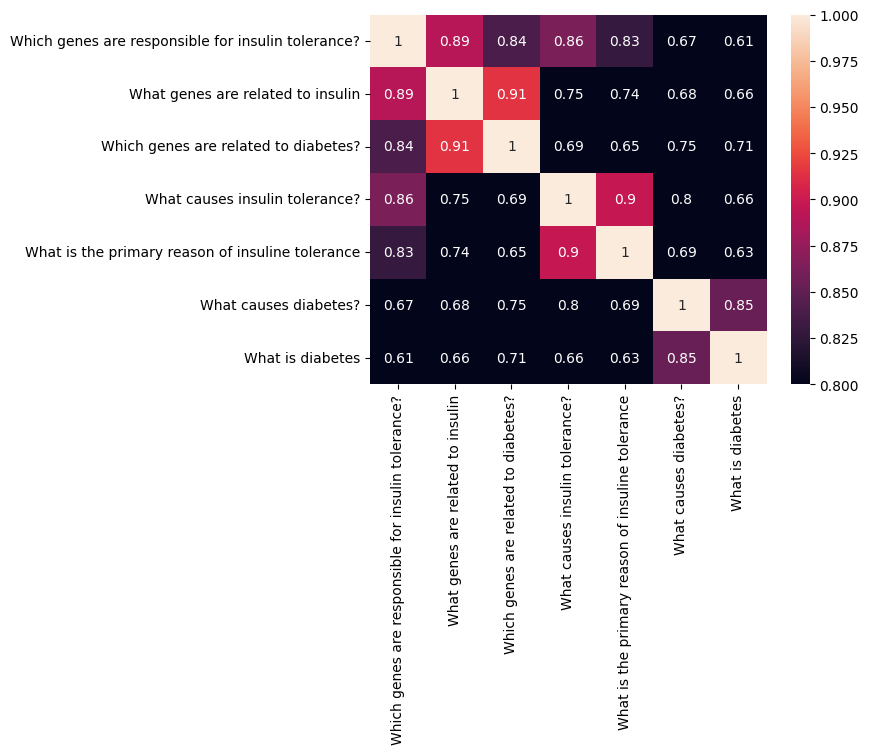

In [13]:
import seaborn as sns
from rag.utils import cosine_similarity_matrix

sim_matr = cosine_similarity_matrix([
    'Which genes are responsible for insulin tolerance?',
    'What genes are related to insulin',
    'Which genes are related to diabetes?',
    'What causes insulin tolerance?',
    'What is the primary reason of insuline tolerance',
    'What causes diabetes?',
    'What is diabetes',
], embedder)

sns.heatmap(sim_matr, vmin=0.8, annot=True);

In [5]:
doc_ids

[Document(id='26546829#3', text="etiology consisting of multiple genetic variants as established by genome wide \nassociation studies. Secondary factors, obesity, metabolic syndrome, diabetes, \nrenal disease, estrogen and antipsychotics can increase the likelihood of \nclinical presentation of an individual with predisposed genetic susceptibility \nto hyperlipoproteinemia. The genetic profiles studied are far from complete and \nthere is room for further characterization of genes influencing lipid levels. \nGenetic assessment can help identify patients at risk for developing \ndyslipidemias and for treatment decisions based on 'risk allele' profiles. This \nreview will present the current information on the genetics and pathophysiology \nof disorders that cause dyslipidemias.", score=0.0, doc_type='chunk', meta={}),
 Document(id='26018251#0', text='Genome-wide association studies in human type 2 diabetes (T2D) have renewed \ninterest in the pancreatic islet as a contributor to T2D ris